[![preview notebook](https://img.shields.io/static/v1?label=render%20on&logo=github&color=87ce3e&message=GitHub)](https://github.com/open-atmos/PySDM/blob/main/examples/PySDM_examples/deJong_Mackay_et_al_2023/figs_6_7_8.ipynb)
[![launch on mybinder.org](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/open-atmos/PySDM.git/main?urlpath=lab/tree/examples/PySDM_examples/deJong_Mackay_et_al_2023/figs_6_7_8.ipynb)
[![launch on Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/open-atmos/PySDM/blob/main/examples/PySDM_examples/deJong_Mackay_et_al_2023/figs_6_7_8.ipynb)

## Sensitivity to Ec (coalescence efficiency)

In [1]:
import sys
if 'google.colab' in sys.modules:
    !pip --quiet install open-atmos-jupyter-utils
    from open_atmos_jupyter_utils import pip_install_on_colab
    pip_install_on_colab('PySDM-examples')

In [2]:
from matplotlib import pyplot
from PySDM_examples.deJong_Mackay_et_al_2023 import Settings0D
from PySDM_examples.deJong_Mackay_et_al_2023 import run_box_breakup
from open_atmos_jupyter_utils import show_plot
import numpy as np

from PySDM.dynamics.collisions.coalescence_efficiencies import ConstEc, Straub2010Ec
from PySDM.dynamics.collisions.breakup_fragmentations import Exponential, AlwaysN, Straub2010Nf
from PySDM.physics import si

finished Ec=1.0
[[     0.        0.        0.        0.  ]
 [998971.28      0.   998971.28      0.  ]
 [  1013.43      0.     1013.43      0.  ]]


finished Ec=0.9
[[      0.         0.         0.         0.  ]
 [2351083.68       0.   2117998.12  222207.12]
 [ 216970.64       0.    195200.09   20488.63]]


finished Ec=0.8
[[      0.         0.         0.         0.  ]
 [6376614.05       0.   5102963.73 1206902.97]
 [9931776.88       0.   7885179.78 1917788.48]]


finished Ec=0.7
[[       0.          0.          0.          0.  ]
 [11635359.67        0.    8154591.14  3327335.79]
 [34663858.8         0.   24281504.96 10237258.62]]


finished Straub
[[      0.         0.         0.         0.  ]
 [1015141.72       0.   1012161.81    2780.09]
 [   9211.03       0.      7912.68    1202.23]]


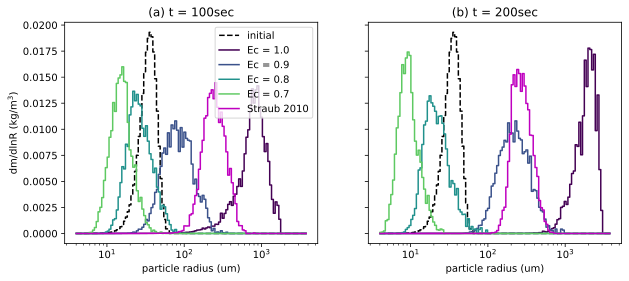

In [3]:
rmin = 0.1 * si.um
vmin = 4/3 * np.pi * rmin**3
settings = Settings0D(fragmentation=AlwaysN(n=8))

settings.n_sd = 2**13
settings.radius_bins_edges = np.logspace(
    np.log10(4.0 * si.um), np.log10(4000 * si.um), num=128, endpoint=True
)

settings.warn_overflows = False
settings._steps = [0, 100, 200]  # pylint: disable=protected-access
cmap = pyplot.get_cmap('viridis')
legend_entries = []

Ec_vals = [1.0, 0.9, 0.8, 0.7]

res = run_box_breakup(settings, [0])
fig, ax = pyplot.subplots(ncols=2,sharey=True,figsize=(10,4),dpi=200)
ax[0].step(res.x, res.y[0]*settings.rho, color='k', linestyle='--', label='initial')
ax[1].step(res.x, res.y[0]*settings.rho, color='k', linestyle='--', label='initial')

for (i, Ec) in enumerate(Ec_vals):
    settings.coal_eff = ConstEc(Ec=Ec)
    res = run_box_breakup(settings)
    print("finished Ec="+str(Ec))
    for (j, step) in enumerate(settings._steps):  # pylint: disable=protected-access
        if j == 0:
            continue
        lbl = 'Ec = ' + str(Ec)
        if Ec == 1.0:
            lbl = 'Ec = 1.0'
        ax[j-1].step(res.x, res.y[j]*settings.rho, color=cmap(i/len(Ec_vals)),
                label= lbl if lbl not in pyplot.gca().get_legend_handles_labels()[1] else '')
    print(res.rates)


settings.coal_eff = Straub2010Ec()
res = run_box_breakup(settings)
for (j, step) in enumerate(settings._steps):  # pylint: disable=protected-access
    if j == 0:
        continue
    lbl = 'Straub 2010'
    ax[j-1].step(res.x, res.y[j]*settings.rho, color='m', label= lbl if lbl not in pyplot.gca().get_legend_handles_labels()[1] else '')
print("finished Straub")
print(res.rates)

ax[0].set_xscale("log")
ax[1].set_xscale("log")
ax[0].set_xlabel("particle radius (um)")
ax[1].set_xlabel("particle radius (um)")
ax[0].set_ylabel("dm/dlnR (kg/m$^3$)")
ax[0].legend()
ax[0].set_title("(a) t = 100sec")
ax[1].set_title("(b) t = 200sec")
show_plot('fig6_Ec_sensitivity.pdf')

## Sensitivity to n_f

finished nf=1
[[     0.              0.              0.              0.        ]
 [833103.35            0.         792001.08333333  41102.26666667]]


finished nf=4
[[     0.              0.              0.              0.        ]
 [973282.24166667      0.         924764.89166667  47907.16666667]]


finished nf=16
[[      0.               0.               0.               0.        ]
 [2045663.46666667       0.         1942552.825        90445.5       ]]


finished nf=64
[[       0.                0.                0.                0.        ]
 [23590744.20833333        0.         22456173.86666667   653528.13333333]]


4.768389119586232e-13 [[     0.              0.              0.              0.        ]
 [919038.68333333      0.         876605.325       39519.39166667]]


1.192097279896558e-13 [[      0.               0.               0.               0.        ]
 [1231335.35             0.         1178624.14166667   46321.64166667]]


2.980243199741395e-14 [[      0.               0.               0.               0.        ]
 [2642596.46666667       0.         2523742.5          82857.95      ]]


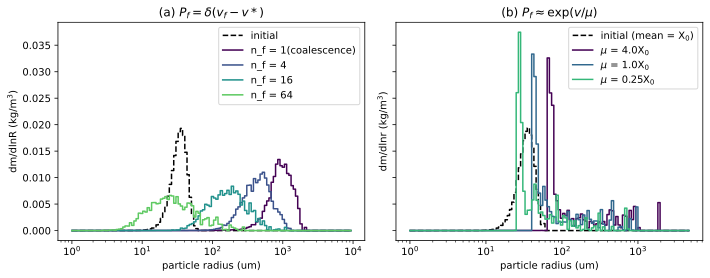

In [4]:
# Constant n_f
settings0 = Settings0D()
settings0.coal_eff = ConstEc(Ec=0.95)
settings0.n_sd = 2**13
settings0.radius_bins_edges = np.logspace(
    np.log10(1e0 * si.um), np.log10(1e4 * si.um), num=128, endpoint=True
)
cmap = pyplot.get_cmap('viridis')
legend_entries = []
nf_vals = [1, 4, 16, 64]
res = run_box_breakup(settings0, [0])

fig, ax = pyplot.subplots(ncols=2,sharey=True,figsize=(10,4),dpi=200)
ax[0].step(res.x, res.y[0]*settings0.rho, color='k', linestyle='--', label='initial')
for (i, nf) in enumerate(nf_vals):
    settings = Settings0D(fragmentation=AlwaysN(n=nf))
    settings._steps = [0, 120]  # pylint: disable=protected-access
    settings.dt = 1 * si.s
    settings.coal_eff = settings0.coal_eff
    settings.n_sd = settings0.n_sd
    settings.radius_bins_edges = settings0.radius_bins_edges
    settings.warn_overflows = False

    res = run_box_breakup(settings)
    print("finished nf="+str(nf))
    for (j, step) in enumerate(settings._steps):  # pylint: disable=protected-access
        if j == 0:
            continue
        lbl = 'n_f = ' + str(nf)
        if nf == 1:
            lbl += '(coalescence)'
        ax[0].step(res.x, res.y[j]*settings.rho, color=cmap(i/len(nf_vals)),
                label= lbl if lbl not in pyplot.gca().get_legend_handles_labels()[1] else '')
    print(res.rates)
ax[0].set_xscale("log")
ax[0].set_xlabel("particle radius (um)")
ax[0].set_ylabel("dm/dlnR (kg/m$^3$)")
ax[0].legend()
ax[0].set_title(r"(a) $P_f = \delta(v_f - v*)$")


# Exponential fragmentation
settings0 = Settings0D()
settings0.n_sd = 2**10
settings0.radius_bins_edges = np.logspace(
            np.log10(1.0 * si.um), np.log10(5000 * si.um), num=128, endpoint=True
        )
cmap = pyplot.get_cmap('viridis')
legend_entries = []

X0 = settings0.X0
mu_vals = [4*X0, X0, X0/4]
vmin = 0.1 * si.um**3
nfmax = None
Ec = 0.95
settings0.coal_eff=ConstEc(Ec=Ec)

res = run_box_breakup(settings0, [0])
ax[1].step(res.x, res.y[0]*settings0.rho, color='k', linestyle='--', label='initial (mean = X$_0$)')
for (i, mu) in enumerate(mu_vals):
    settings = Settings0D(fragmentation=Exponential(scale=mu, vmin=vmin, nfmax=nfmax))
    settings._steps = [0, 120]  # pylint: disable=protected-access
    settings.dt = 1 * si.s
    settings.warn_overflows = False
    settings.coal_eff = settings0.coal_eff
    settings.n_sd = settings0.n_sd
    settings.radius_bins_edges = settings0.radius_bins_edges

    res = run_box_breakup(settings)
    print(mu, res.rates)
    for (j, step) in enumerate(settings._steps):  # pylint: disable=protected-access
        if j == 0:
            continue
        lbl = r'$\mu$ = ' + str(round(mu/X0,2)) + 'X$_0$'
        ax[1].step(res.x, res.y[j]*settings.rho, color=cmap(i/len(mu_vals)),linestyle='-',
                label= lbl if lbl not in pyplot.gca().get_legend_handles_labels()[1] else '')

ax[1].set_xscale("log")
ax[1].set_xlabel("particle radius (um)")
ax[1].set_ylabel("dm/dlnr (kg/m$^3$)")
ax[1].legend()
ax[1].set_title(r"(b) $P_f \approx \exp (v/\mu)$")
pyplot.tight_layout()
show_plot('fig7_Pf_sensitivity_constEc.pdf')

## Fully Stochastic: Straub 2010

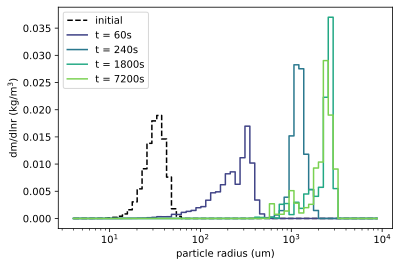

In [5]:
settings = Settings0D(fragmentation=Straub2010Nf(vmin=vmin, nfmax=nfmax))
settings._steps = [0, 60, 240, 1800, 7200]  # pylint: disable=protected-access
cmap = pyplot.get_cmap('viridis')
legend_entries = []

settings.n_sd = 2**11
settings.warn_overflows = False
settings.radius_bins_edges = np.logspace(
    np.log10(4.0 * si.um), np.log10(1e4 * si.um), num=64, endpoint=True
)
vmin = X0 * 1e-3
nfmax = 10
settings.coal_eff=Straub2010Ec()

res = run_box_breakup(settings, [0])
pyplot.figure(figsize=(6,4),dpi=200)
pyplot.step(res.x, res.y[0]*settings.rho, color='k', linestyle='--', label='initial')

res = run_box_breakup(settings)
for (j, step) in enumerate(settings._steps):  # pylint: disable=protected-access
    if j == 0:
        continue
    pyplot.step(
        res.x, res.y[j] * settings.rho,
        color=cmap(j/len(settings._steps)),  # pylint: disable=protected-access
        linestyle='-',
        label=f't = {step}s'
    )

pyplot.xscale("log")
pyplot.xlabel("particle radius (um)")
pyplot.ylabel("dm/dlnr (kg/m$^3$)")
pyplot.legend()
show_plot('fig8_straub_box.pdf')